In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
######## 데이터 불러오기 #########
# 기물(챔피언) 데이터 불러오기
champion_data = pd.read_csv('./tft_game_dataset/TFT_Champion_CurrentVersion.csv', encoding='utf-8')
print(champion_data.dtypes)

# 아이템 데이터 불러오기
item_data = pd.read_csv('./tft_game_dataset/TFT_Item_CurrentVersion_Add_Img.csv', encoding='utf-8')
print(item_data.dtypes)

# 게임 매치 데이터 불러오기
match_data_path = [f'./tft_game_dataset/{x}' for x in os.listdir('./tft_game_dataset') if x.endswith('MatchData.csv')]

# 게임 매치 데이터 합치기
match_data = pd.DataFrame()
for path in match_data_path:
    tier = path.split('_')[3]  # 티어 정보 추출
    df = pd.read_csv(path, encoding='utf-8')
    df['tier'] = tier  # 티어 정보 컬럼 추가
    match_data = pd.concat([match_data, df], ignore_index=True)
print(match_data.dtypes)

name                object
cost                 int64
health               int64
defense              int64
attack               int64
attack_range         int64
speed_of_attack    float64
dps                  int64
skill_name          object
skill_cost          object
origin              object
class               object
dtype: object
id        int64
name     object
Image    object
dtype: object
gameId             object
gameDuration      float64
level               int64
lastRound           int64
Ranked              int64
ingameDuration    float64
combination        object
champion           object
tier               object
dtype: object


In [3]:
# 데이터 결측치 확인
print('결측치 확인')
print(champion_data.isnull().sum())
print(item_data.isnull().sum())
print(match_data.isnull().sum())

결측치 확인
name               0
cost               0
health             0
defense            0
attack             0
attack_range       0
speed_of_attack    0
dps                0
skill_name         0
skill_cost         0
origin             0
class              0
dtype: int64
id       0
name     0
Image    0
dtype: int64
gameId            0
gameDuration      0
level             0
lastRound         0
Ranked            0
ingameDuration    0
combination       0
champion          0
tier              0
dtype: int64


In [4]:
### 게임 매치 데이터 이상치 확인하기
## gameId를 기준으로 이상치 탐색
'''
gameId 별로 8개의 데이터가 있어야함 # 플레이어 8명
만약 8개 초과 또는 미만인경우 정상적인 데이터가 아닐 수 있음
'''
df = match_data.copy()
# gameId 별 데이터 개수 세기
df_grouped = df.groupby('gameId').size().reset_index(name='counts')

# 이상치 게임 ID 추출
anomaly_gameIds = df_grouped[df_grouped['counts'] != 8]
print(anomaly_gameIds)

# 이상치 게임 ID 리스트로 변환
anomaly_gameIds_lst = anomaly_gameIds['gameId'].tolist()
print('이상치 게임 ID')
print(anomaly_gameIds_lst)

              gameId  counts
2432   KR_4263820118      16
10243  KR_4313697214      16
12053  KR_4318806255       7
12525  KR_4320079059      16
20067  KR_4335870255       7
25323  KR_4344513862      16
27702  KR_4347884427      16
34207  KR_4357966612      16
34976  KR_4358922415      16
37414  KR_4361594426      16
37573  KR_4361773461      16
38720  KR_4362846604      16
39928  KR_4364453473      16
40896  KR_4365284161      16
43914  KR_4378896137      16
44448  KR_4381231118      16
45665  KR_4387025966      16
45726  KR_4387247645      16
45850  KR_4388134708      16
47563  KR_4393787119      16
49148  KR_4398618214      16
이상치 게임 ID
['KR_4263820118', 'KR_4313697214', 'KR_4318806255', 'KR_4320079059', 'KR_4335870255', 'KR_4344513862', 'KR_4347884427', 'KR_4357966612', 'KR_4358922415', 'KR_4361594426', 'KR_4361773461', 'KR_4362846604', 'KR_4364453473', 'KR_4365284161', 'KR_4378896137', 'KR_4381231118', 'KR_4387025966', 'KR_4387247645', 'KR_4388134708', 'KR_4393787119', 'KR_4398618

In [5]:
# 이상치 검증하기
'''
총 찾은 이상치는 21개 중 2개는 모자르고 나머지는 16개로 두개의 데이터가 중복으로 되어있는거 같음
확인해서 중복값이면 유니크 처리하고 모자라는건 제거
'''
for gameId in anomaly_gameIds_lst:
    try:
        temp_df = df[df['gameId'] == gameId]

        # 1등부터 8등까지 챔피언이 전부 같다면 같은 데이터라고 판단
        for i in range(1,9):
            tmp = temp_df[temp_df['Ranked'] == i].reset_index(drop=True)

            # 1~8등 검증 같으면 처음으로
            if tmp.loc[0, 'champion'] == tmp.loc[1, 'champion']:
                continue

            # 하나라도 다르면 이상치 데이터로 판단
            else:
                print(f'gameId {gameId} 이상치 데이터')
                break
            
    except Exception as e:
        print(f'오류 발생: gameId {gameId}, 오류: {e}')

오류 발생: gameId KR_4318806255, 오류: 1
오류 발생: gameId KR_4335870255, 오류: 1


In [6]:
## 이상치 데이터 처리하기
'''
16개인 데이터는 중복인걸로 확인됨 따라서 유니크 처리해서 사용
7개인 데이터는 이상치로 제거
'''
anomaly_gameIds_7 = anomaly_gameIds[anomaly_gameIds['counts'] == 7]['gameId'].tolist()
anomaly_gameIds_16 = anomaly_gameIds[anomaly_gameIds['counts'] == 16]['gameId'].tolist()
match_data_cleaned = match_data.drop(match_data[match_data['gameId'].isin(anomaly_gameIds_7)].index)
print('제거된 데이터 수(이상치 제거 후): ', len(match_data) - len(match_data_cleaned))

## 이상치 유니크 처리
'''
중복된 데이터만 따로 뽑아서 하나 만들고 기존꺼에서는 전부 제거 이후에 유니크 처리 후 합치기
'''

# 중복 데이터만 추출
duplicate_data = match_data_cleaned[match_data_cleaned['gameId'].isin(anomaly_gameIds_16)]

# 기존 데이터에서 중복 데이터 제거
temp = match_data_cleaned.copy()
temp = temp.drop(temp[temp['gameId'].isin(anomaly_gameIds_16)].index)

# 중복 데이터 유니크 처리 후 합치기
for id in anomaly_gameIds_16:
    unique_data = duplicate_data[duplicate_data['gameId'] == id].drop_duplicates(subset=['Ranked'])
    temp = pd.concat([temp, unique_data], ignore_index=True)

# 최종 데이터 확인
match_data = temp.copy()
print('제거된 데이터 수(유니크 처리 후): ', len(match_data_cleaned) - len(temp))
print('최종 데이터 수: ', match_data.shape)

# 정제된 게임 매치 데이터 저장하기
# match_data.to_csv('./tft_game_dataset/cleaned_TFT_MatchData.csv', index=False, encoding='utf-8')

제거된 데이터 수(이상치 제거 후):  14
제거된 데이터 수(유니크 처리 후):  152
최종 데이터 수:  (399832, 9)


In [7]:
import json

def fast_parse(x):
    return json.loads(x.replace("'", '"'))

match_data['champion'] = match_data['champion'].apply(fast_parse)

In [25]:
# 챔피언수는 최소값은 6 미만, 최대값은 10 초과를 이상치로 판단
anomaly_champion = match_data.copy()
anomaly_champion['anomaly'] = match_data['champion'].apply(lambda x: len(x) <= 5 or len(x) > 10)
anomaly_champion_cleaned = anomaly_champion[anomaly_champion['anomaly'] == False]

# 인게임 시간이 짧은 경우 제거 15분 미만
anomaly_champion_cleaned = anomaly_champion_cleaned[anomaly_champion_cleaned['ingameDuration'] >= 900]

# 인게임 시간이 지나치게 긴경우 제거 1시간 초과
anomaly_champion_cleaned = anomaly_champion_cleaned[anomaly_champion_cleaned['ingameDuration'] <= 3600]

# 이상치 제거된 최종 데이터 변수 재 할당
match_data = anomaly_champion_cleaned.copy().reset_index(drop=True)
print('최종 데이터 수(이상치 제거 후): ', match_data.shape)

최종 데이터 수(이상치 제거 후):  (394211, 11)


In [ ]:
# 챔피언 등장 빈도수 확인
match_data['champion_names'] = match_data['champion'].apply(lambda x: list(x.keys()))
champion_list = []
for champ in match_data['champion_names']:
    champion_list.extend(champ)

# 챔피언 수 세기
from collections import Counter
champion_counts = Counter(champion_list)
print('챔피언 등장 상위 10개')
print(champion_counts.most_common(10))

챔피언 등장 상위 10개
[('Vi', 123154), ('Blitzcrank', 119367), ('Kassadin', 108228), ('Ezreal', 105909), ('MissFortune', 105210), ('WuKong', 101465), ('Malphite', 98627), ('ChoGath', 94629), ('Kayle', 90850), ('Shen', 90529)]


In [34]:
# 상위 챔피언을 사용하는 유저의 평균 등수
top_champions = [champ for champ, count in champion_counts.most_common(10)]
top_champion_avg_ranks = {}
for champ in top_champions:
    ranks = []
    for idx, row in match_data.iterrows():
        if champ in row['champion_names']:
            ranks.append(row['Ranked'])
    avg_rank = np.mean(ranks)
    top_champion_avg_ranks[champ] = avg_rank
print('상위 챔피언을 사용하는 유저의 평균 등수')
print(top_champion_avg_ranks)

상위 챔피언을 사용하는 유저의 평균 등수
{'Vi': np.float64(4.315986488461601), 'Blitzcrank': np.float64(4.400939958279927), 'Kassadin': np.float64(4.37214029641128), 'Ezreal': np.float64(4.375794313986535), 'MissFortune': np.float64(3.8723790514209675), 'WuKong': np.float64(4.4068299413590895), 'Malphite': np.float64(4.346943534731868), 'ChoGath': np.float64(4.250219277388538), 'Kayle': np.float64(4.268981838194827), 'Shen': np.float64(4.5067547415745235)}


In [37]:
# 4등 이상 유저들이 많이 사용하는 챔피언
top4_champion_list = []
for champ in match_data[match_data['Ranked'] <= 4]['champion_names']:
    top4_champion_list.extend(champ)

top4_champion_counts = Counter(top4_champion_list)
print('4등 이상 유저들이 많이 사용하는 챔피언 상위 10개')
print(top4_champion_counts.most_common(10))

4등 이상 유저들이 많이 사용하는 챔피언 상위 10개
[('Vi', 65896), ('MissFortune', 65277), ('Blitzcrank', 61924), ('Kassadin', 56461), ('Ezreal', 55413), ('Malphite', 52272), ('WuKong', 52148), ('ChoGath', 51864), ('Kayle', 49306), ('Ashe', 46341)]


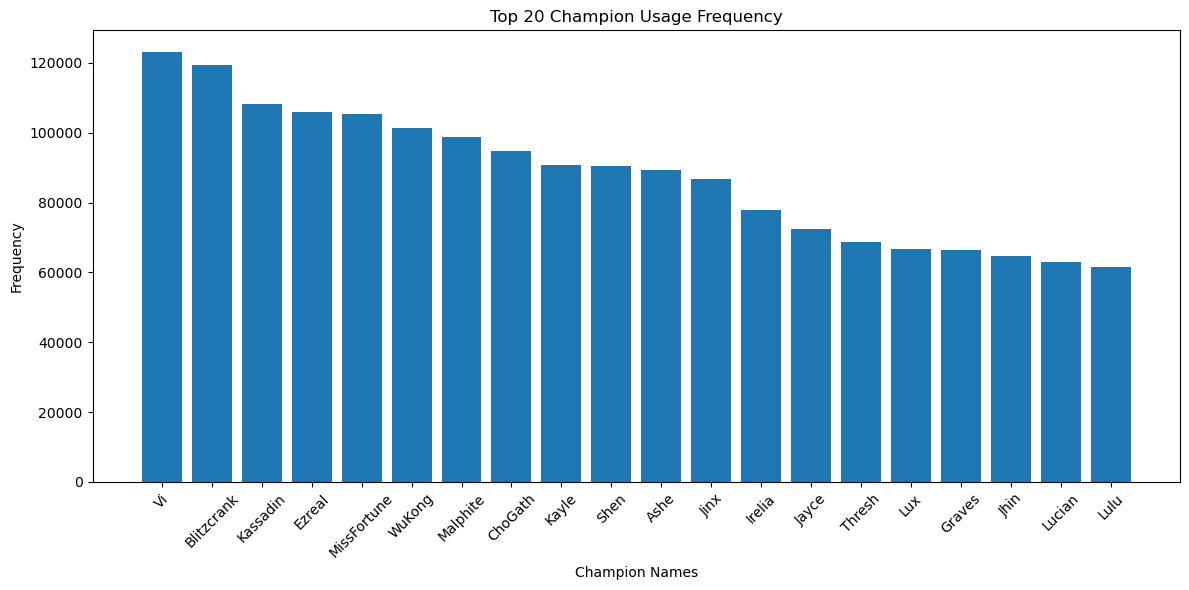

In [56]:
# 챔피언 사용 빈도 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
champion_names, champion_freqs = zip(*champion_counts.most_common(20))
plt.bar(champion_names, champion_freqs)
plt.xlabel('Champion Names')
plt.ylabel('Frequency')
plt.title('Top 20 Champion Usage Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

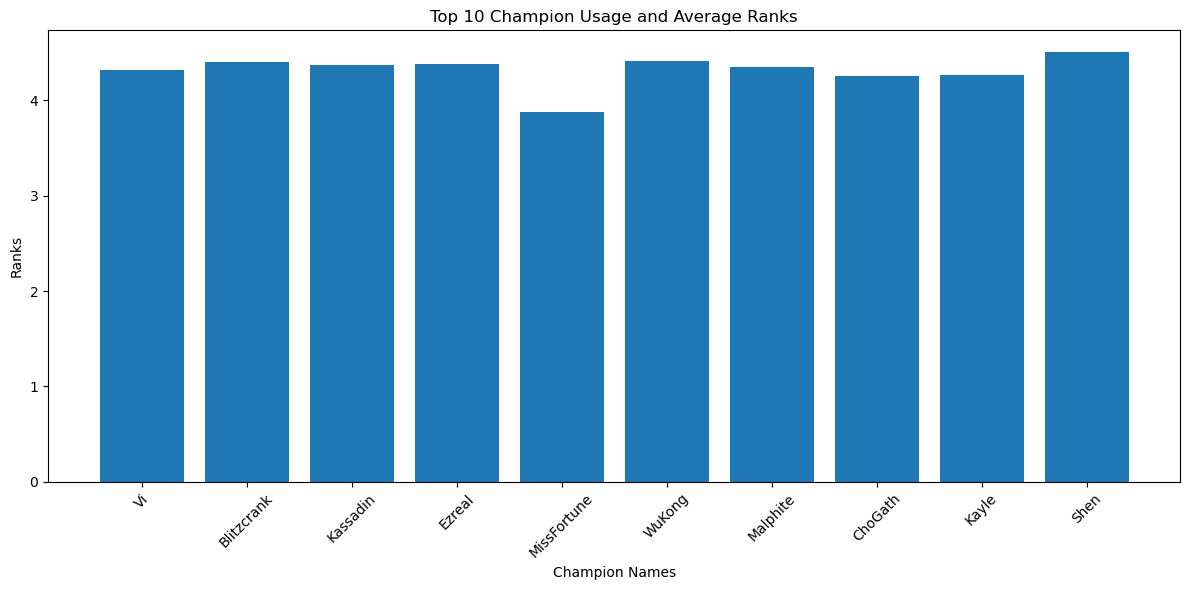

In [57]:
# 상위 10등 챔피언 평균 등수
plt.figure(figsize=(12,6))
champion_names, avg_ranks = zip(*top_champion_avg_ranks.items())
plt.bar(champion_names, avg_ranks)
plt.xlabel('Champion Names')
plt.ylabel('Ranks')
plt.title('Top 10 Champion Usage and Average Ranks')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

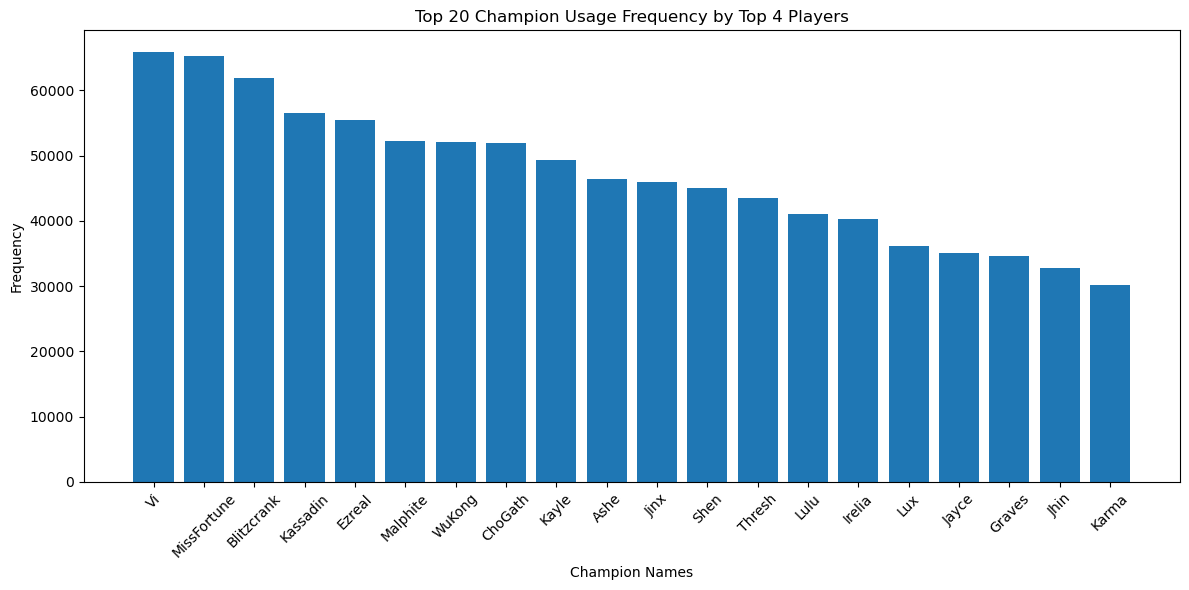

In [58]:
# 4등 이상 유저들의 챔피언 사용 빈도 시각화
plt.figure(figsize=(12,6))
champion_names, champion_freqs = zip(*top4_champion_counts.most_common(20))
plt.bar(champion_names, champion_freqs)
plt.xlabel('Champion Names')
plt.ylabel('Frequency')
plt.title('Top 20 Champion Usage Frequency by Top 4 Players')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

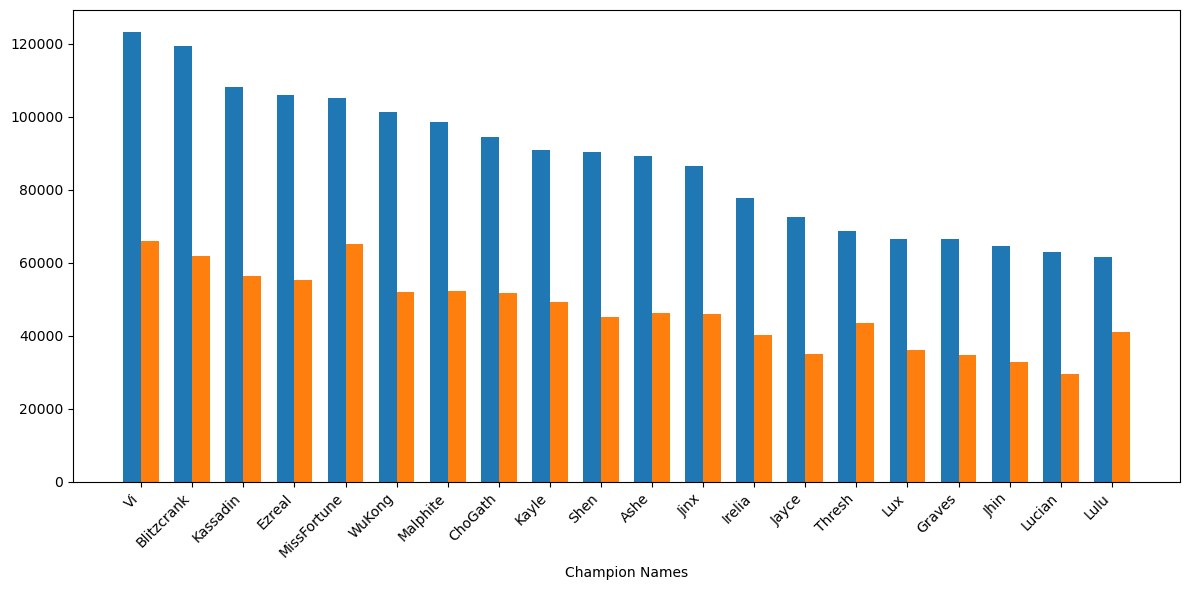

In [59]:
# 전체 유저 상위 20개 챔피언 빈도와 상위 4등 유저들의 상위 20개 챔피언 빈도 비교 시각화
labels, overall_counts = zip(*champion_counts.most_common(20))
top4_counts = [top4_champion_counts.get(label, 0) for label in labels]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - width/2, overall_counts, width, label='Overall Users')
rects2 = ax.bar(x + width/2, top4_counts, width, label='Top 4 Players')
ax.set_xlabel('Champion Names')
ax.set_xticks(x)                     # x 위치
ax.set_xticklabels(labels, rotation=45, ha='right')  # 해당 위치 레이블
plt.tight_layout()
plt.show()